## Install Dependencies


### torch, torchvision

In [10]:
# install torch and torchvision
!pip3 install torch torchvision torchaudio torchtext --extra-index-url https://download.pytorch.org/whl/cu116

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu116


### pytorch3d

In [11]:
import os
import torch

try:
    import pytorch3d
except ModuleNotFoundError:
    !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
    !tar xzf 1.10.0.tar.gz
    os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
    !pip install git+https://github.com/facebookresearch/pytorch3d.git

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  404k    0  404k    0     0  1737k      0 --:--:-- --:--:-- --:--:-- 1737k
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/pytorch3d.git to /tmp/pip-req-build-2j05b44e
  Running command git clone -q https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-2j05b44e
     |████████████████████████████████| 50 kB 5.7 MB/s 
     |████████████████████████████████| 42 kB 1.1 MB/s 
  Created wheel for pytorch3d: filename=pytorch3d-0.7.1-cp38-cp38-linux_x86_64.whl size=46622914 sha256=f429ec2e59ece314cccd56e33a2a406b8dc6f5e51d615ecb25336487b386bffe
  Stored in directory: /tmp/pip-ephem-wheel-cache-d8xou5jr/wheels/5e/a7/7c/814c3888eaaecaaf0f533faeb3c68

In [12]:
import pytorch3d
pytorch3d.__version__

'0.7.1'

### SMPL / Meshes

In [13]:
!pip install smplpytorch
!pip install chumpy
!pip install trimesh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 5.6 MB/s 
  Created wheel for chumpy: filename=chumpy-0.70-py3-none-any.whl size=58286 sha256=e65fae9a3694b8691e1572ffdacc816bd4ae8d297d068171df1237f3b10caaa5
  Stored in directory: /root/.cache/pip/wheels/d9/a2/b8/b8aeeeaeb01b5002085156add1aed832f2fb03e79d0f22dfed
Successfully built chumpy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 669 kB 32.2 MB/s 


### CLIP

In [14]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-3ertgjwy
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-3ertgjwy
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369408 sha256=c704209281ebe0750308260a084dd717bf50e9ada397dcb8b18da54433a75b89
  Stored in directory: /tmp/pip-ephem-wheel-cache-_am0znbp/wheels/ab/4f/3a/5e51521b55997aa6f0690e095c08824219753128ce8d9969a3
Successfully built clip


## GPU

In [15]:
import torch

torch.cuda.is_available()

False

In [16]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [17]:
# GPU or CPU
gpu, cpu = None, None
if torch.cuda.is_available():
    gpu = torch.device("cuda:0")
    torch.cuda.set_device(gpu)
else:
    cpu = torch.device("cpu")
dev = gpu if gpu is not None else cpu
dev

device(type='cpu')

## Setup

### Codebase Loading

In [84]:
!rm -rf project #remove if it already exists 
!git clone https://github.com/B4Farouk/smpl-dr-clip project
!rm -rf sample_data

Cloning into 'project'...
remote: Enumerating objects: 700, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 700 (delta 40), reused 50 (delta 21), pack-reused 622
Receiving objects: 100% (700/700), 67.59 MiB | 46.42 MiB/s, done.
Resolving deltas: 100% (408/408), done.


### Local Imports 

In [57]:
from project.aux_functions import *

from project.smpl import SMPLwrapper, mesh_from
from project.textures import TexturesFactory
from project.rendering import CamerasFactory, Renderer
from project.clipwrapper import CLIPwrapper

from project.optimization import OptimEnv, init_weights
from project.model import compose, SimpledCLIPContext

import trimesh

import clip

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Test: SMPL and Rendering

In [81]:
# initalize a textures factory
txfactory = TexturesFactory(device=dev)
colored_reference_SMPL = trimesh.load("project/SMPL_female_with_colors.obj", process=False)
# use the texture factory to create a texture generator: a function that takes faces and creates a texture
def texture_generator(verts,faces):
  return txfactory.from_image(colored_reference_SMPL ,verts, faces)
# pose and shape initalization
pose_vect = torch.zeros((1, 72), device=dev) # theta, used in optimization
shape_vect = torch.ones((1, 10), device=dev) # beta, not used in optimization
# create the smpl model
smpl_model = SMPLwrapper(model=None, batchsize=5, txmapping=texture_generator, device=dev) #model=None uses the default model
# create the mesh
meshes = smpl_model.meshes(theta=pose_vect, beta=shape_vect)

In [82]:
# create a cameras factory
camsfactory = CamerasFactory(device=dev)
# cameras' spherical coordinates
radiuses = [2]*5
azimuths = (0, 45, 135, -45, -135)
elevations = [10]*5
coords = (radiuses, azimuths, elevations)
# create cameras using cameras factory
cameras = camsfactory.fov_persp_scs(coords=coords, fov=60, frustrum_depth=(1, 100))
# create a renderer
renderer = Renderer(device=dev, cameras=cameras)
# render the textured meshes generated by SMPL
test_imgs_t = renderer.render(meshes)
# shape of the rendered images
test_imgs_t.shape

torch.Size([5, 244, 244, 4])

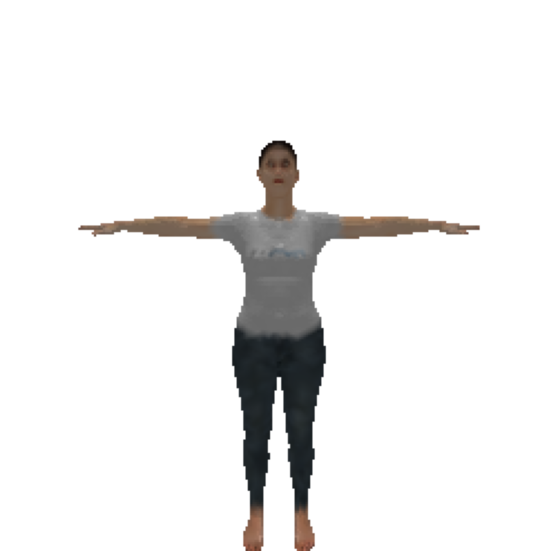

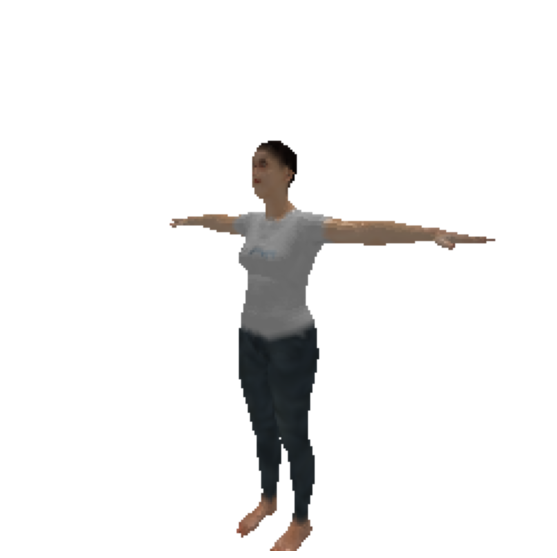

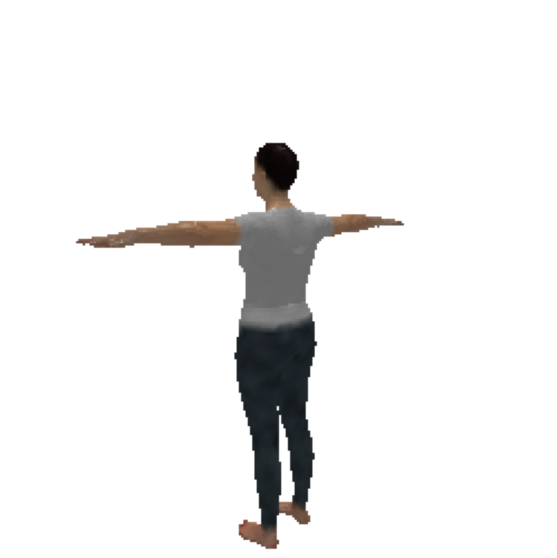

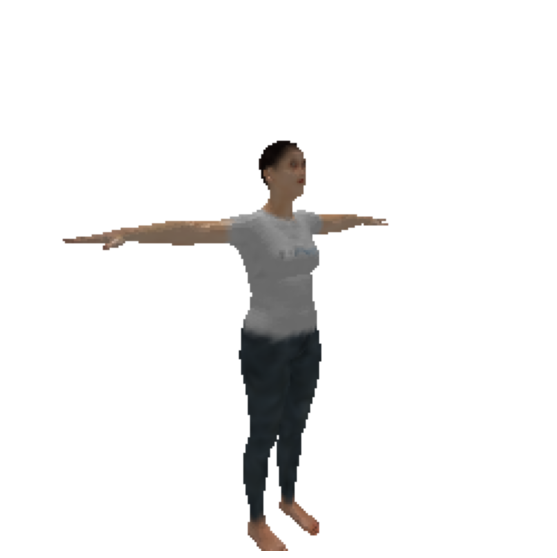

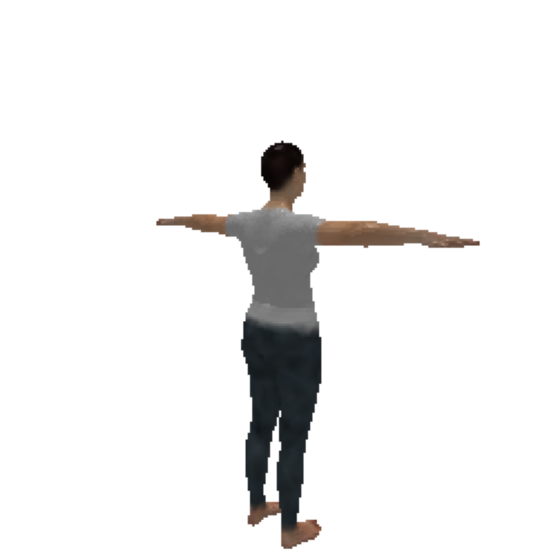

In [83]:
# a quick visualization of the rendered mesh
for test_img_t in test_imgs_t:
  plot_image_t(test_img_t)

## Test: CLIP

In [70]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [71]:
clip_model = CLIPwrapper(model_name="ViT-B/32", device=dev)

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 212MiB/s]


#### Test: Our Implementation of CLIP Image Preprocessing

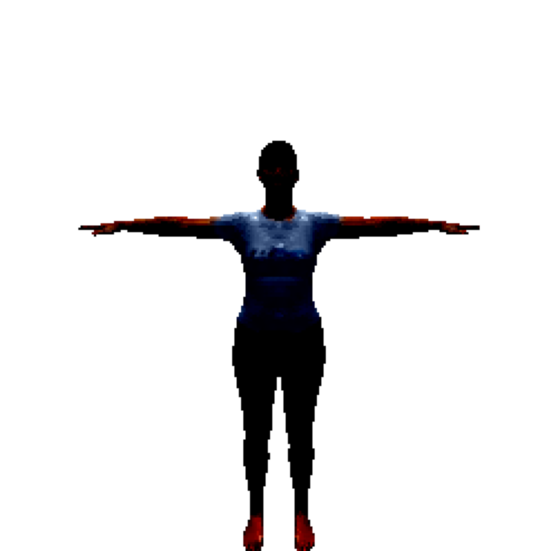

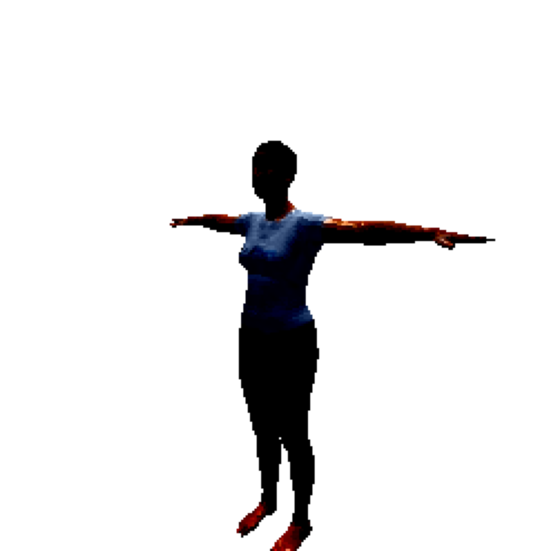

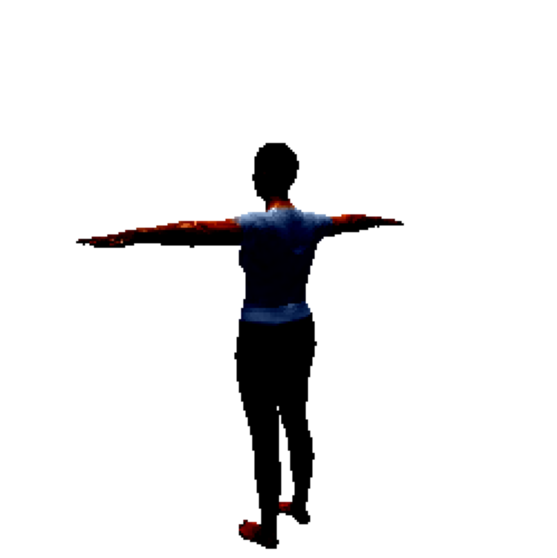

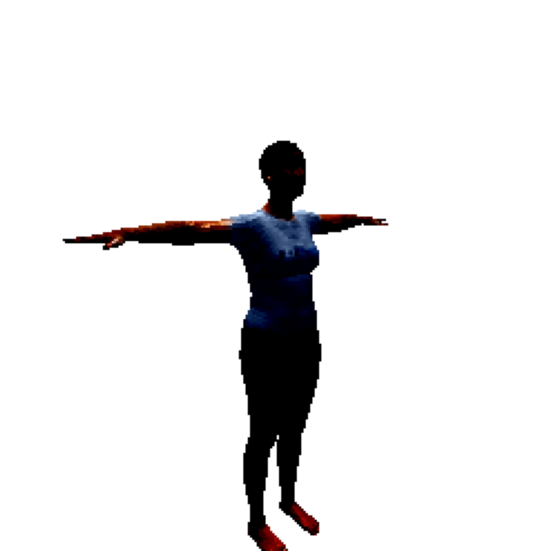

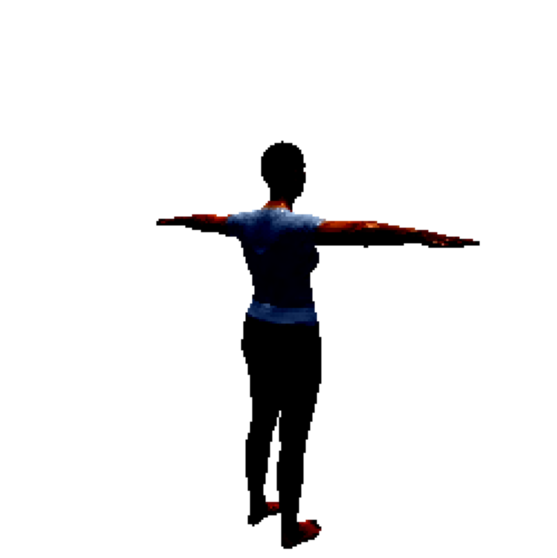

In [94]:
proc_test_imgs_t = torch.permute(clip_model.proc_imgs(test_imgs_t), (0, 2, 3, 1)) # N 3 W H => N W H 3 so 0 1 2 3 => 0 2 3 1
# a quick visualization of the processed images (matplotlib automatically clamps the pixels)
for proc_test_img_t in proc_test_imgs_t:
  plot_image_t(proc_test_img_t)

#### Test: How much does CLIP recognize our mesh and the position it is in ?

In [113]:
# a prompt describing the previous image
pmt_emb = clip_model.pmt_emb("""a white human wearing a light grey T-shirt and blue pants, standing up on her straight feet. She is looking upfront with both hands apart and at the shoulder level.""")
imgs_embs = clip_model.imgs_embs(test_imgs_t)

In [114]:
imgs_embs.shape, pmt_emb.shape

(torch.Size([5, 512]), torch.Size([1, 512]))

In [115]:
img_emb = imgs_embs.mean(axis=0, keepdims=True)
float(cos_dist(img_emb, pmt_emb))

0.27134037017822266

In [121]:
cosine_distances = torch.Tensor([cos_dist(img_emb.unsqueeze(0), pmt_emb) for img_emb in imgs_embs])
cosine_distances

tensor([0.2791, 0.2918, 0.2403, 0.2717, 0.2502])

In [122]:
float(cosine_distances.mean())

0.2666051983833313

## MODELS


In [ ]:
# create a model factory
model_context = SimpledCLIPContext(smpl_model, renderer, clip_model) 
MODELS = {
    "P1": model_context.create(
        prompt="""a white human wearing a light grey T-shirt and blue pants, standing up on her straight feet. She is looking upfront with both hands up.""")
    }

In [ ]:
def run_optimization(model, n_passes=1000):
  pose, shape = init_weights(device=dev) # weights used in optimization
  optim_config = {
      "lr": 1e-3,
      "betas": (0.9, 0.999),
      "sch_factor": 0.5,
      "sch_patience": 5,
      "sch_threshold": 1e-3,
      "sch_cooldown": 50,
      "sch_verbose": True
  }
  optimenv = OptimEnv(model=model, weights=[pose, shape], activate_lr_sch=True, config=optim_config)
  result = optimenv.optimize(pose=pose, shape=shape, n_passes=n_passes, tracker_settings={"loss":{"interleaving": 10}, "pose": {"interleaving": 100}, "shape": {"interleaving": 100}})
  return result

def intermediate_views(result, coords):
  camera = camsfactory.fov_persp_scs(coords=coords, fov=60, frustrum_depth=(1, 100))
  renderer = Renderer(device=dev, cameras=camera)
  pose_shape = zip(result["tracked"]["poses"]["pose"], result["tracked"]["shapes"]["shape"])
  for pose, shape in pose_shape:
    pose, shape = pose.to(dev), shape.to(dev)
    mesh = smpl_model.mesh(theta=pose, beta=shape)
    image = renderer.render(mesh)
    plot_image_t(image)

In [ ]:
result = run_optimization(MODELS["P1"])

In [ ]:
plot_losses(result["tracked"]["losses"])

In [ ]:
intermediate_views(result, coords=(2.25, 0, 3))

In [ ]:
result2 = run_optimization(MODELS["P1"], n_passes=500)

In [ ]:
plot_losses(result2["tracked"]["losses"])

In [ ]:
intermediate_views(result2, coords=(2.25, 0, 3))